In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [11]:
# loading data set
words = open('names.txt', 'r').read().splitlines()
print('Input:')
words[:10]

#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], [] # X is input to neural net. Y is label for each input
    for w in words:
        
        context = [0] * block_size # create padded context of Zero tokens
        for ch in w + '.': # concat . token to end of word and iterate through charcters
            ix = stoi[ch] # assign index of ch to variable ix
            X.append(context) # append context to input X
            Y.append(ix) # append index of ch to labels Y
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Input:
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [70]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = ((1 - self.momentum) * self.running_mean) + (self.momentum * xmean)
                self.running_var = ((1 - self.momentum) * self.running_var) + (self.momentum * xvar)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

vocab_size = len(stoi)
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),  BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'Total parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

Total parameters: 47551


In [71]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would remove
    for p in parameters:
        p.grad = None # reset grad
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break # REMOVE AFTER DEBUG

      0/ 200000: 3.2823


layer 2 (      Tanh): mean: -0.00, std: 0.63, saturated: 3.38%
layer 5 (      Tanh): mean: +0.00, std: 0.64, saturated: 2.50%
layer 8 (      Tanh): mean: -0.01, std: 0.64, saturated: 2.31%
layer 11 (      Tanh): mean: +0.00, std: 0.64, saturated: 2.03%
layer 14 (      Tanh): mean: +0.00, std: 0.64, saturated: 2.09%


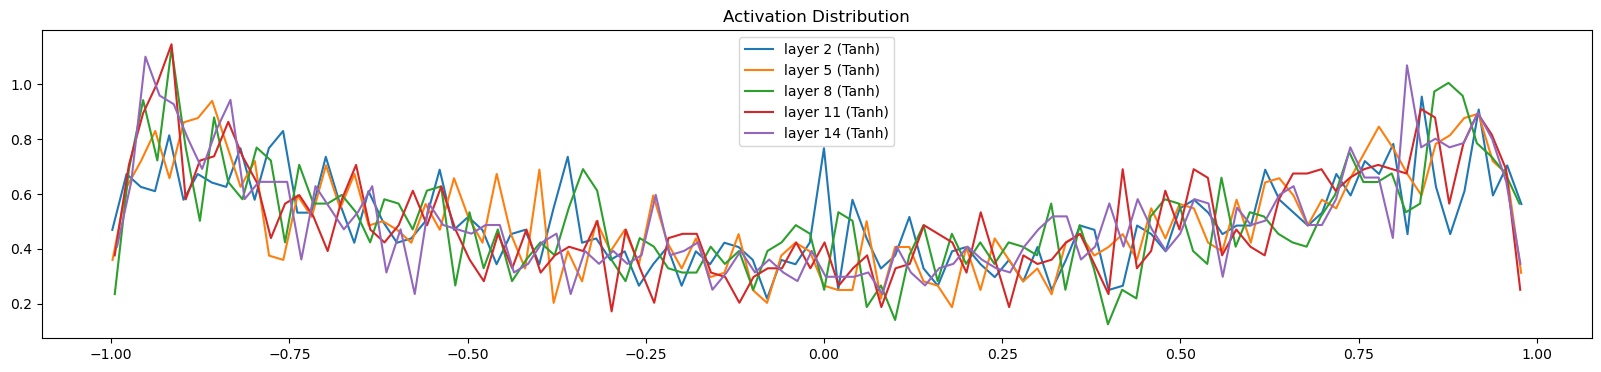

In [72]:
# visualize histograms
# this plot shows how many parameters are being squashed to 1 or -1 by activation function tanh
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distribution');

layer 2 (      Tanh): mean: +0.00, std: 0.00
layer 5 (      Tanh): mean: -0.00, std: 0.00
layer 8 (      Tanh): mean: -0.00, std: 0.00
layer 11 (      Tanh): mean: +0.00, std: 0.00
layer 14 (      Tanh): mean: -0.00, std: 0.00


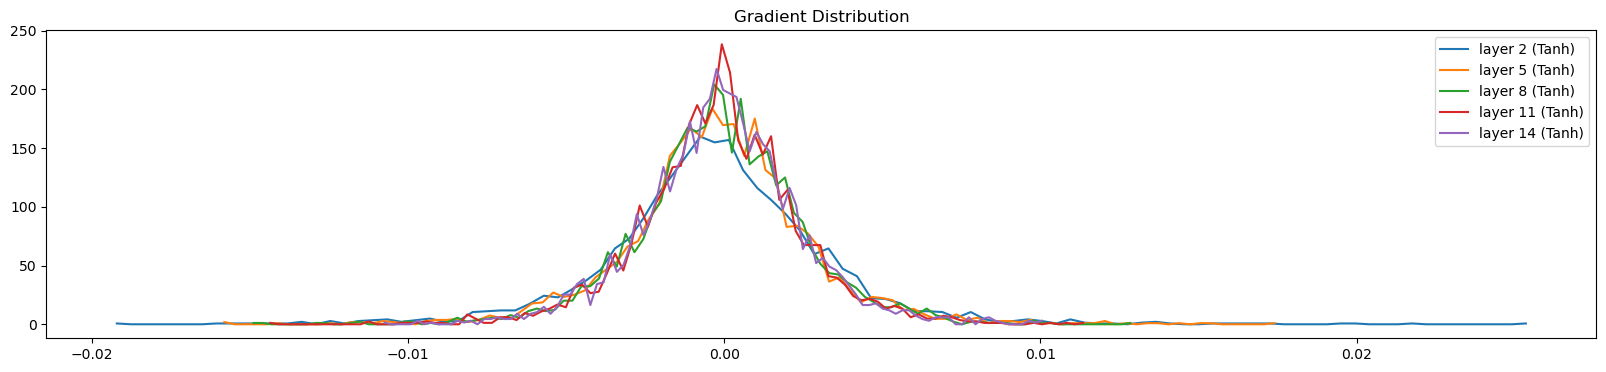

In [73]:
# visualize histograms
# this plot shows the distribution of the gradients of our parameters
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+.2f, std: %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient Distribution');

weight   (27, 10) | mean -0.000000 | std 1.003324e-02 | grad:data 1.048911e-02
weight  (30, 100) | mean +0.000130 | std 8.072657e-03 | grad:data 2.617187e-02
weight (100, 100) | mean -0.000064 | std 6.439423e-03 | grad:data 3.828220e-02
weight (100, 100) | mean -0.000013 | std 5.666539e-03 | grad:data 3.384034e-02
weight (100, 100) | mean +0.000076 | std 5.161889e-03 | grad:data 3.079113e-02
weight (100, 100) | mean +0.000035 | std 4.882048e-03 | grad:data 2.893907e-02
weight  (100, 27) | mean -0.000188 | std 8.600896e-03 | grad:data 5.164743e-02


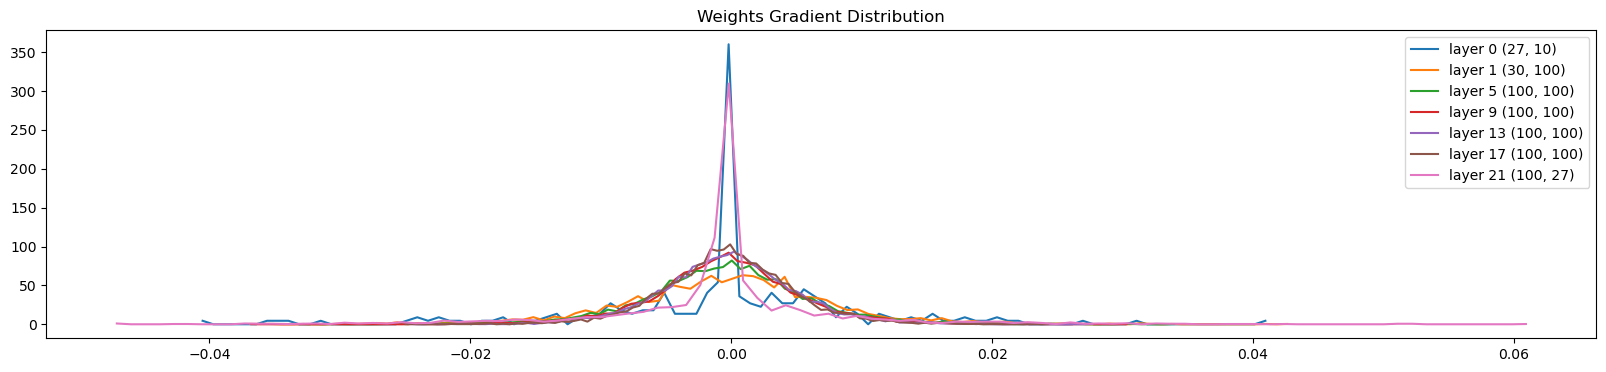

In [74]:
# this plot shows the ratio of gradients to data values for our parameters
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');

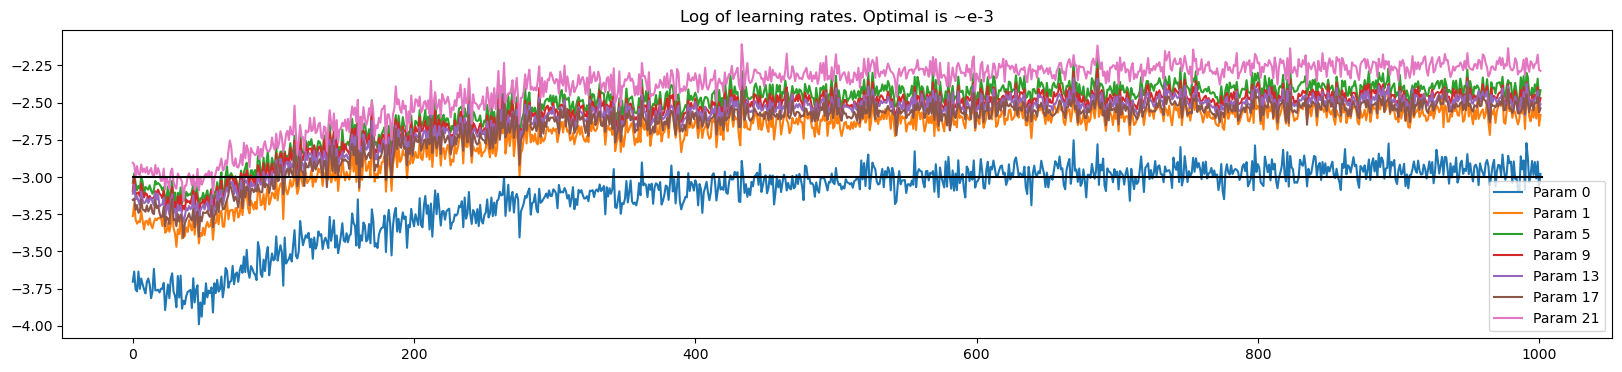

In [75]:
#  this plot shows the update rates for our layers as a ratio of the log10 of (each parameters gradients multiplied by the learning rate, divided by its value)
# can be used to tune learning rates to aim for e-3, which is optimal
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('Param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.title('Log of learning rates. Optimal is ~e-3')
plt.legend(legends);